<a href="https://colab.research.google.com/github/Gooogr/Brain2Image/blob/master/%20sub_notebooks/Brain_MNIST_sklearn_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Linear EEG signals classifier based on MindBigData dataset MNIST of the brain: http://mindbigdata.com/opendb/index.html <br>


In [1]:
import sys
import os
import gc
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time
# import torch; torch.utils.backcompat.broadcast_warning.enabled = True
# from torch.utils.data import DataLoader
# from torchvision import transforms, datasets
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim
# import torch.backends.cudnn as cudnn; cudnn.benchmark = True
# from scipy.fftpack import fft, rfft, fftfreq, irfft, ifft, rfftfreq
import numpy as np

import pandas as pd
pd.set_option('display.max_colwidth', 100)
import ast

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
SEED=42

In [3]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)
# ! ln -s "/content/drive/My Drive" "/content/mydrive"

### Data preparations

In [4]:
def get_dataset(dataset_name):
    try:
        if dataset_name == 'MNIST':
            ! wget -q https://datahub.io/DavidVivancos/mindbigdata-ep-v1.0-bitter-chipmunk-96/r/mindbigdata-ep-v1.0.zip?v=1 \
                -O dataset.zip
            ! unzip -q dataset.zip
        if dataset_name == 'Imagenet':
            pass
    except:
        raise ValueError('Specify type of dataset: MNIST or Imagenet')    

 FILE FORMAT:

The data is stored in a very simple text format including:

[id]: a numeric, only for reference purposes.

[event] id, a integer, used to distinguish the same event captured at different brain locations, used only by multichannel devices (all except MW).

[device]: a 2 character string, to identify the device used to capture the signals, "MW" for MindWave, "EP" for Emotive Epoc, "MU" for Interaxon Muse & "IN" for Emotiv Insight.

[channel]: a string, to indentify the 10/20 brain location of the signal, with possible values:
 
	MindWave 	"FP1"
	EPOC 	"AF3, "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"
	Muse 	"TP9,"FP1","FP2", "TP10"
	Insight 	"AF3,"AF4","T7","T8","PZ" 

[code]: a integer, to indentify the digit been thought/seen, with possible values 0,1,2,3,4,5,6,7,8,9 or -1 for random captured signals not related to any of the digits.

[size]: a integer, to identify the size in number of values captured in the 2 seconds of this signal, since the Hz of each device varies, in "theory" the value is close to 512Hz for MW, 128Hz for EP, 220Hz for MU & 128Hz for IN, for each of the 2 seconds.

[data]: a coma separated set of numbers, with the time-series amplitude of the signal, each device uses a different precision to identify the electrical potential captured from the brain: integers in the case of MW & MU or real numbers in the case of EP & IN. 

In [5]:
get_dataset('MNIST')

In [6]:
def txt2float(s):
    '''
    Convert text string to numpy array with float32 dtype.
    '''
    row = list(ast.literal_eval(s))
    result = np.array(row, dtype=np.float32)
    return result

In [7]:
%%time 
column_names = ['id', 'event', 'device', 'channel', 'code', 'size', 'data']
df = pd.read_table('./EP1.01.txt', names=column_names) #delim_whitespace=True, 
print('Shape of the dataset:', df.shape)
df.data = df.data.apply(txt2float)

Shape of the dataset: (910476, 7)
CPU times: user 6min 47s, sys: 20.4 s, total: 7min 7s
Wall time: 7min 11s


In [8]:
gc.collect()

519

In [9]:
df.head(15)

,id,event,device,channel,code,size,data
0,67635,67635,EP,AF3,6,260,"[4395.385, 4382.564, 4377.436, 4387.1797, 4395.8975, 4398.4614, 4396.923, 4391.795, 4391.282, 43..."
1,67636,67635,EP,F7,6,260,"[4489.231, 4475.385, 4474.359, 4486.6665, 4498.974, 4496.41, 4486.6665, 4489.7437, 4498.4614, 45..."
2,67637,67635,EP,F3,6,260,"[4538.4614, 4528.718, 4524.615, 4526.154, 4532.3076, 4538.4614, 4535.385, 4528.205, 4528.718, 45..."
3,67638,67635,EP,FC5,6,260,"[4207.6924, 4205.641, 4200.5127, 4194.359, 4198.4614, 4213.846, 4219.4873, 4210.769, 4202.564, 4..."
4,67639,67635,EP,T7,6,260,"[4497.9487, 4498.4614, 4494.8716, 4497.9487, 4506.154, 4508.205, 4501.5386, 4497.436, 4498.4614,..."
5,67640,67635,EP,P7,6,260,"[4203.077, 4192.8203, 4194.8716, 4204.615, 4208.205, 4207.6924, 4208.205, 4206.154, 4202.564, 42..."
6,67641,67635,EP,O1,6,260,"[4203.077, 4193.3335, 4194.8716, 4207.1797, 4220.5127, 4222.564, 4217.436, 4212.3076, 4210.2563,..."
7,67642,67635,EP,O2,6,260,"[4229.7437, 4216.923, 4207.1797, 4215.385, 4234.8716, 4238.974, 4230.769, 4222.564, 4215.385, 42..."
8,67643,67635,EP,P8,6,260,"[4245.641, 4236.41, 4218.4614, 4220.0, 4239.4873, 4246.154, 4244.1025, 4242.564, 4231.282, 4225...."
9,67644,67635,EP,T8,6,260,"[4506.6665, 4501.026, 4496.923, 4496.923, 4504.1025, 4514.359, 4519.4873, 4511.795, 4498.4614, 4..."


In [10]:
print('Channels amount:', df.groupby(['event']).agg({'channel': 'nunique'})['channel'].unique())

Channels amount: [14]


In [11]:
f"Number of unique events (measurements): {len(df['event'].unique())}"

'Number of unique events (measurements): 65034'

Every event has 14 channels

In [12]:
# random_event = np.random.choice(df.event.unique())
# data_sample = df[df['event'] == 67635]
# fig = plt.figure(figsize=(15, 5))
# for row in data_sample['data']:
#     plt.plot(row)
# plt.title('Random EGG signal based on 14 Emotive EPOC sensors (event №{})'.format(random_event))    
# plt.show()     

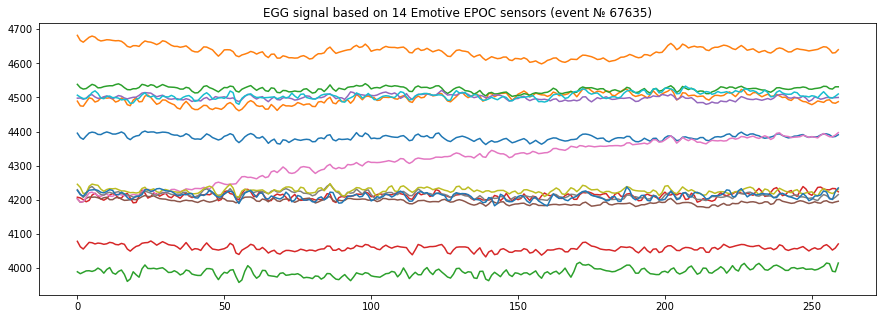

In [13]:
data_sample = df[df['event'] == 67635]
fig = plt.figure(figsize=(15, 5))
for row in data_sample['data']:
    plt.plot(row)
plt.title('EGG signal based on 14 Emotive EPOC sensors (event № 67635)')    
plt.show()  

In [14]:
np.all(df['size'].values == 260)

False

In [15]:
df['size'].value_counts().head(10)

260    606214
256    173614
264     61586
261     44072
257     12362
252      4956
265      3640
268      2884
253       294
272       196
Name: size, dtype: int64

Filter values signal length. We need events with length equal to 260.

In [16]:
# Find events with 260 length
clear_grouping = df[df['size'] == 260].groupby('event').agg({'id':'nunique'})
# Save only complete events with 14 channels (sanity check)
correct_events = clear_grouping[clear_grouping['id'] == 14].index
# Filter data
filtered_df = df[df['event'].isin(correct_events)]

In [17]:
filtered_df.head(20)

,id,event,device,channel,code,size,data
0,67635,67635,EP,AF3,6,260,"[4395.385, 4382.564, 4377.436, 4387.1797, 4395.8975, 4398.4614, 4396.923, 4391.795, 4391.282, 43..."
1,67636,67635,EP,F7,6,260,"[4489.231, 4475.385, 4474.359, 4486.6665, 4498.974, 4496.41, 4486.6665, 4489.7437, 4498.4614, 45..."
2,67637,67635,EP,F3,6,260,"[4538.4614, 4528.718, 4524.615, 4526.154, 4532.3076, 4538.4614, 4535.385, 4528.205, 4528.718, 45..."
3,67638,67635,EP,FC5,6,260,"[4207.6924, 4205.641, 4200.5127, 4194.359, 4198.4614, 4213.846, 4219.4873, 4210.769, 4202.564, 4..."
4,67639,67635,EP,T7,6,260,"[4497.9487, 4498.4614, 4494.8716, 4497.9487, 4506.154, 4508.205, 4501.5386, 4497.436, 4498.4614,..."
5,67640,67635,EP,P7,6,260,"[4203.077, 4192.8203, 4194.8716, 4204.615, 4208.205, 4207.6924, 4208.205, 4206.154, 4202.564, 42..."
6,67641,67635,EP,O1,6,260,"[4203.077, 4193.3335, 4194.8716, 4207.1797, 4220.5127, 4222.564, 4217.436, 4212.3076, 4210.2563,..."
7,67642,67635,EP,O2,6,260,"[4229.7437, 4216.923, 4207.1797, 4215.385, 4234.8716, 4238.974, 4230.769, 4222.564, 4215.385, 42..."
8,67643,67635,EP,P8,6,260,"[4245.641, 4236.41, 4218.4614, 4220.0, 4239.4873, 4246.154, 4244.1025, 4242.564, 4231.282, 4225...."
9,67644,67635,EP,T8,6,260,"[4506.6665, 4501.026, 4496.923, 4496.923, 4504.1025, 4514.359, 4519.4873, 4511.795, 4498.4614, 4..."


In [18]:
targets = filtered_df.groupby('event')['code'].mean().values #It is not important mean, max or min
print('Targets amount:', len(targets))

Targets amount: 43301


In [19]:
# Stack sub-arrays and transpond matrix 
stack_data = np.vstack(filtered_df['data'].values)
print(stack_data.shape)

(606214, 260)


In [20]:
def normalize_rows(x: np.ndarray):
    """
    Normalizes each row of the matrix x to have unit length.
    Based on: https://necromuralist.github.io/neural_networks/posts/normalizing-with-numpy/
    Args:
     ``x``: A numpy matrix of shape (n, m)
    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return x/np.linalg.norm(x, ord=2, axis=1, keepdims=True)

In [21]:
# ## Scale data per row (like PerciveLab)
# scaled_data = normalize_rows(stack_data)



In [22]:
# # Scale data per clumns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(stack_data)
# scaled_data = stack_data  # uncomment to skip skaling

In [23]:
# Split data in groups. One group ~ one target label
complete_samples_amounts = len(filtered_df)/14
split_data = np.array(np.split(scaled_data, complete_samples_amounts, axis=0))
print(split_data.shape)

(43301, 14, 260)


In [24]:
# Reshape 14 vectors in one
data = np.reshape(split_data, [split_data.shape[0], split_data.shape[1] * split_data.shape[2]])
data.shape

(43301, 3640)

In [25]:
# # Make final dataframe with with data - target
# result_df = pd.DataFrame(zip(data, targets), columns=['data', 'target'])
# result_df.head()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


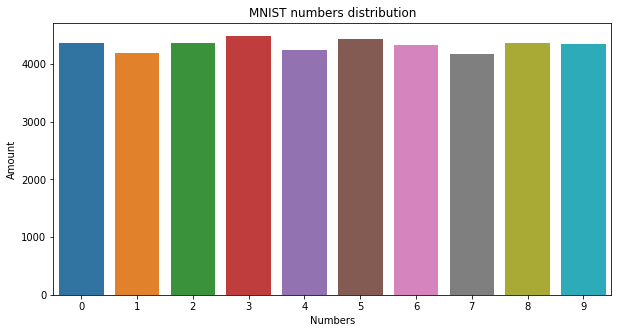

In [26]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(targets)
ax.set(xlabel='Numbers', ylabel='Amount')
plt.title('MNIST numbers distribution')
plt.show()

Dataset seems quite balanced. Let's make index partition.

In [27]:
idx_full = list(range(len(data)))

In [28]:
idx_train, idx_test, y_train, y_test = train_test_split(idx_full, targets, test_size=0.2, stratify=targets, random_state=SEED)

In [29]:
print(len(y_train), len(y_test))

34640 8661


In [30]:
X_train = data[idx_train, :]
X_test = data[idx_test, :]

### PCA and t-SNE

In [31]:
from sklearn.decomposition import PCA

Let's estimate with PCA method the dimension amount that needs to explain 95% of the datasets variance. 

In [32]:
%%time
pca = PCA(random_state=SEED)
pca.fit(X_train)

CPU times: user 2min 31s, sys: 4.81 s, total: 2min 36s
Wall time: 1min 21s


In [33]:
pca_cumsum = np.cumsum(pca.explained_variance_ratio_)
d_95 = np.argmax(pca_cumsum >= 0.95) + 1
print('The number of dimensions that explain 95 % of the variance :', d_95)

The number of dimensions that explain 95 % of the variance : 47


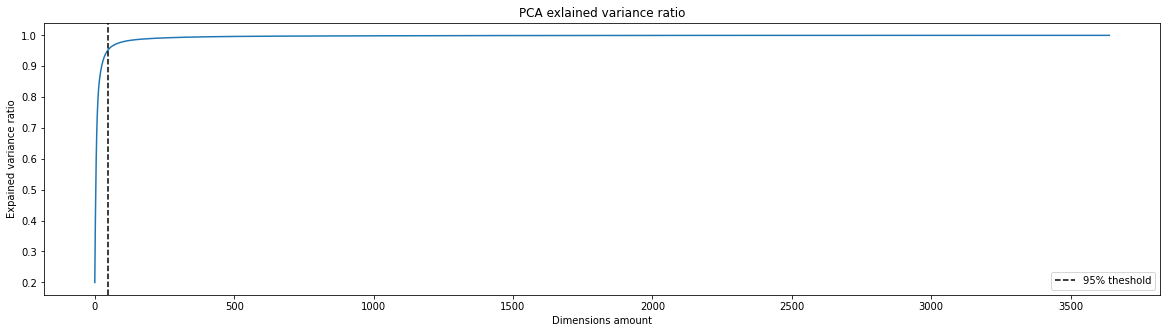

In [34]:
plt.figure(figsize=(20, 5))
plt.plot(pca_cumsum)
plt.title('PCA exlained variance ratio')
plt.xlabel('Dimensions amount')
plt.ylabel('Expained variance ratio')
plt.axvline(x=d_95, color='k', linestyle='--', label='95% theshold')
plt.legend()
plt.show()

T-SNE clasterization

In [35]:
from sklearn.manifold import TSNE
import time

In [47]:
_, X_tsne, _, y_tsne = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=SEED)
print("t-SNE sample size:", len(X_tsne))

In [56]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=250, n_jobs=-1)
tsne_results = tsne.fit_transform(X_tsne)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3464 samples in 3.241s...
[t-SNE] Computed neighbors for 3464 samples in 119.085s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3464
[t-SNE] Computed conditional probabilities for sample 2000 / 3464
[t-SNE] Computed conditional probabilities for sample 3000 / 3464
[t-SNE] Computed conditional probabilities for sample 3464 / 3464
[t-SNE] Mean sigma: 0.101180
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.857315
[t-SNE] KL divergence after 1000 iterations: 1.986050
t-SNE done! Time elapsed: 223.8792188167572 seconds


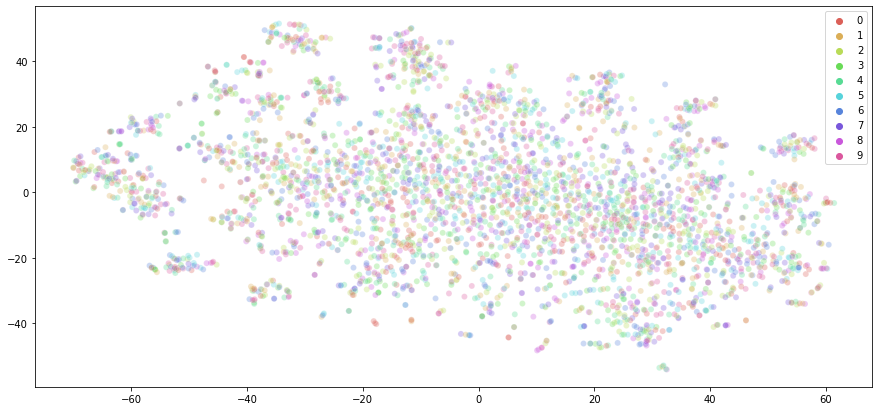

In [57]:
plt.figure(figsize=(15,7))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=y_tsne,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)
plt.show()

### Linear model

https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn import metrics


In [ ]:
%%time
clf = RidgeClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=5)

CPU times: user 1min 12s, sys: 4.04 s, total: 1min 16s
Wall time: 41.3 s


In [ ]:
scores

array([0.14131062, 0.13207275, 0.13481524, 0.13943418, 0.13741339])

In [ ]:
# %%time
# clf = RandomForestClassifier()
# clf.fit(X_train, y_train)
# forest_preds = clf.predict(X_test)
# accuracy_score(forest_preds, y_test)

In [ ]:
# accuracy_score(forest_preds, y_test)


0.11922632794457275

In [ ]:
############################################################################